## Imports

In [ ]:
import numpy as np
import random
import time
import gymnasium as gym
import torch
from evogym.envs import *
from evogym import EvoViewer, get_full_connectivity
from neural_controller import NeuralController, set_weights
import matplotlib.pyplot as plt

SEED = [42,43,44,45,46]

## Utils

In [2]:
def run_experiment(algorithm, num_runs=5, num_generations=100, scenario='DownStepper-v0', steps=500):
    """
    Run an evolutionary algorithm multiple times and store key results.

    Parameters:
        algorithm (function): The function that runs an evolutionary algorithm (e.g., `evolution_strategy`).
        num_runs (int): Number of times to run the algorithm.
        num_generations (int): Number of generations per run.
        scenario (str): Environment scenario.
        steps (int): Number of steps per simulation.

    Returns:
        best_overall_weights (list): Best neural network weights found across all runs.
        best_overall_fitness (float): Best fitness score found across all runs.
        mean_fitness_per_generation (np.array): Mean best fitness per generation across all runs.
        mean_fitnesses (np.array): Mean of mean fitness scores per generation.
        mean_execution_time (float): Mean execution time across all runs.
        std_fitnesses (np.array): Standard deviation of fitness scores per generation.
    """

    # Initialize storage variables
    best_fitnesses_overall = np.zeros(num_generations)  # Sum fitness scores across runs (to average later)
    mean_fitnesses = np.zeros(num_generations)  # Sum mean fitness scores across runs (to average later)
    std_fitnesses = np.zeros(num_generations)  # Sum std fitness scores across runs (to average later)
    
    total_execution_time = 0
    best_overall_fitness = float('-inf')
    best_overall_weights = None

    for i in range(num_runs):
        print(f"\nRunning {algorithm.__name__} {i + 1}/{num_runs}...")

        # Run the algorithm and extract results
        best_weights, best_fitness, best_fitness_scores, mean_fitnesses_run, execution_time, std_fitness_scores_run = algorithm()

        print(f"Best fitness score of run {i + 1}: {best_fitness:.3f}")

        # Accumulate fitness data for averaging
        best_fitnesses_overall += np.array(best_fitness_scores)  
        mean_fitnesses += np.array(mean_fitnesses_run)  
        std_fitnesses += np.array(std_fitness_scores_run)

        # Keep track of the best neural network controller across all runs
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_weights = best_weights

        # Accumulate execution time
        total_execution_time += execution_time

    # Compute the **mean** best fitness per generation across runs
    best_fitnesses_overall /= num_runs
    mean_fitnesses /= num_runs
    std_fitnesses /= num_runs
    mean_execution_time = total_execution_time / num_runs

    print("\nFinal Results After Multiple Runs:")
    print(f"Mean execution time: {mean_execution_time:.2f} seconds")
    print(f"Best fitness found: {best_overall_fitness:.3f}")

    # Plot averaged fitness evolution
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_generations), best_fitnesses_overall, label="Best Fitness per Generation", color='blue')
    plt.fill_between(range(num_generations), best_fitnesses_overall - std_fitnesses, best_fitnesses_overall + std_fitnesses, color='blue', alpha=0.2, label="Std Dev Range")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Score")
    plt.title(f"{algorithm.__name__}: Fitness Evolution in {scenario}")
    plt.legend()
    plt.grid()
    plt.show()

    return best_overall_weights, best_overall_fitness, best_fitnesses_overall, mean_fitnesses, mean_execution_time, std_fitnesses


In [3]:
# ---- VISUALIZATION ----
def visualize_policy(weights):
    set_weights(brain, weights)  # Load weights into the network
    env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
    sim = env.sim
    viewer = EvoViewer(sim)
    viewer.track_objects('robot')
    state = env.reset()[0]  # Get initial state
    for t in range(STEPS):  
        # Update actuation before stepping
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
        action = brain(state_tensor).detach().numpy().flatten() # Get action
        viewer.render('screen') 
        state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            env.reset()
            break

    viewer.close()
    env.close()


## Random

In [5]:
NUM_GENERATIONS = 100  # Number of generations to evolve
STEPS = 500
SCENARIO = 'DownStepper-v0'
# SEED = random.randint(0, 10000)
# np.random.seed(SEED)
# random.seed(SEED)


robot_structure = np.array([ 
[1,3,1,0,0],
[4,1,3,2,2],
[3,4,4,4,4],
[3,0,0,3,2],
[0,0,0,0,2]
])



connectivity = get_full_connectivity(robot_structure)
env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
sim = env.sim
input_size = env.observation_space.shape[0]  # Observation size
output_size = env.action_space.shape[0]  # Action size

brain = NeuralController(input_size, output_size)

# ---- FITNESS FUNCTION ----
def evaluate_fitness(weights, view=False):
        set_weights(brain, weights)  # Load weights into the network
        env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
        sim = env
        viewer = EvoViewer(sim)
        viewer.track_objects('robot')
        state = env.reset()[0]  # Get initial state
        t_reward = 0
        for t in range(STEPS):  
            # Update actuation before stepping
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
            action = brain(state_tensor).detach().numpy().flatten() # Get action
            if view:
                viewer.render('screen') 
            state, reward, terminated, truncated, info = env.step(action)
            t_reward += reward
            if terminated or truncated:
                env.reset()
                break

        viewer.close()
        env.close()
        return t_reward 


# ---- RANDOM SEARCH ALGORITHM ----
best_fitness = -np.inf
best_weights = None

for generation in range(NUM_GENERATIONS):
    # Generate random weights for the neural network
    random_weights = [np.random.randn(*param.shape) for param in brain.parameters()]
    
    # Evaluate the fitness of the current weights
    fitness = evaluate_fitness(random_weights)
    
    # Check if the current weights are the best so far
    if fitness > best_fitness:
        best_fitness = fitness
        best_weights = random_weights
    
    print(f"Generation {generation + 1}/{NUM_GENERATIONS}, Fitness: {fitness}")

# Set the best weights found
set_weights(brain, best_weights)
print(f"Best Fitness: {best_fitness}")

i = 0
while i < 10:
    visualize_policy(best_weights)
    i += 1

Generation 1/100, Fitness: -0.12167064679549641
Generation 2/100, Fitness: -3.5268446161220766
Generation 3/100, Fitness: -3.548572504776808
Generation 4/100, Fitness: -0.18009917180846982
Generation 5/100, Fitness: -0.08818828974205489
Generation 6/100, Fitness: 0.02586906934710509
Generation 7/100, Fitness: -0.034529999998695216
Generation 8/100, Fitness: -0.10202440641650756
Generation 9/100, Fitness: -0.020286880646432554
Generation 10/100, Fitness: -0.097188835402297
Generation 11/100, Fitness: -0.09996805998968666
Generation 12/100, Fitness: -0.04951920257203751
Generation 13/100, Fitness: -3.437108781699235
Generation 14/100, Fitness: -0.12287750839084541
Generation 15/100, Fitness: -3.2643663021412737
Generation 16/100, Fitness: -3.485602457404588
Generation 17/100, Fitness: -2.300218373568095
Generation 18/100, Fitness: -0.03212701945593832
Generation 19/100, Fitness: -0.18602775674943056
Generation 20/100, Fitness: -3.5039058787191575
Generation 21/100, Fitness: -0.1399006220

## Evolutionary Strategy

In [6]:

# ---- HYPERPARAMETERS ----
MU = 20               # Number of parents
LAMBDA = 20           # Number of offspring per generation
NUM_GENERATIONS = 100  # Number of generations
MUTATION_STD = 0.1    # Standard deviation for Gaussian mutation
STEPS = 500
SCENARIO = 'DownStepper-v0'
# SEED = 42             # Não é suposto não termos seed fixa??

# np.random.seed(SEED)
# random.seed(SEED)
# torch.manual_seed(SEED)

# ---- ENVIRONMENT SETUP ----
robot_structure = np.array([
    [1, 3, 1, 0, 0],
    [4, 1, 3, 2, 2],
    [3, 4, 4, 4, 4],
    [3, 0, 0, 3, 2],
    [0, 0, 0, 0, 2]
])

connectivity = get_full_connectivity(robot_structure)
env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
sim = env.sim
input_size = env.observation_space.shape[0]  # Observation size
output_size = env.action_space.shape[0]  # Action size

# Initialize neural network
brain = NeuralController(input_size, output_size)

# ---- FITNESS FUNCTION ----
def evaluate_fitness(weights, view=False):
    """Evaluates the neural network controller's fitness."""
    set_weights(brain, weights)  # Load weights into the network
    env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
    sim = env.sim
    viewer = EvoViewer(sim)
    viewer.track_objects('robot')
    
    state = env.reset()[0]
    total_reward = 0

    for t in range(STEPS):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = brain(state_tensor).detach().numpy().flatten()
        
        if view:
            viewer.render('screen')

        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        
        if terminated or truncated:
            break

    viewer.close()
    env.close()
    return total_reward

# ---- INITIALIZATION ----
def initialize_population():
    """Initialize the population with random weights."""
    return [[np.random.randn(*param.shape) for param in brain.parameters()] for _ in range(MU)]

def mutate(parent):
    """Mutate an individual by adding Gaussian noise to weights."""
    return [w + MUTATION_STD * np.random.randn(*w.shape) for w in parent]

# ---- (μ + λ) EVOLUTION STRATEGY ----
def evolution_strategy():
    """Run the (μ + λ) Evolution Strategy to optimize the neural controller."""
    population = initialize_population()
    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    start_time = time.time()

    for generation in range(NUM_GENERATIONS):
        # Evaluate fitness of current population
        fitnesses = np.array([evaluate_fitness(ind) for ind in population])

        # Store statistics
        best_fitness_scores.append(np.max(fitnesses))
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        # Generate λ offspring by mutating random parents
        offspring = [mutate(random.choice(population)) for _ in range(LAMBDA)]
        offspring_fitnesses = np.array([evaluate_fitness(ind) for ind in offspring])

        # Combine parents and offspring
        combined_population = population + offspring
        combined_fitnesses = np.concatenate((fitnesses, offspring_fitnesses))

        # Select the top μ individuals for the next generation
        top_indices = np.argsort(combined_fitnesses)[-MU:]
        population = [combined_population[i] for i in top_indices]

        print(f"Generation {generation + 1}: Best Fitness = {best_fitness_scores[-1]:.3f}, Mean Fitness = {mean_fitness_scores[-1]:.3f}")

    end_time = time.time()
    execution_time = end_time - start_time

    # Get the best individual
    best_idx = np.argmax(fitnesses)
    best_weights = population[best_idx]
    best_fitness = fitnesses[best_idx]

    return best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, execution_time, std_fitness_scores



Running evolution_strategy 1/1...
Generation 1: Best Fitness = 0.170, Mean Fitness = -0.712
Generation 2: Best Fitness = 1.041, Mean Fitness = 0.070
Generation 3: Best Fitness = 1.041, Mean Fitness = 0.210
Generation 4: Best Fitness = 1.064, Mean Fitness = 0.367
Generation 5: Best Fitness = 1.064, Mean Fitness = 0.500
Generation 6: Best Fitness = 1.064, Mean Fitness = 0.673
Generation 7: Best Fitness = 1.162, Mean Fitness = 0.856
Generation 8: Best Fitness = 1.162, Mean Fitness = 0.912
Generation 9: Best Fitness = 1.186, Mean Fitness = 0.974
Generation 10: Best Fitness = 1.231, Mean Fitness = 1.023
Generation 11: Best Fitness = 1.350, Mean Fitness = 1.070
Generation 12: Best Fitness = 1.767, Mean Fitness = 1.178
Generation 13: Best Fitness = 1.767, Mean Fitness = 1.238
Generation 14: Best Fitness = 1.767, Mean Fitness = 1.311
Generation 15: Best Fitness = 1.767, Mean Fitness = 1.372
Generation 16: Best Fitness = 1.772, Mean Fitness = 1.483
Generation 17: Best Fitness = 1.834, Mean Fit

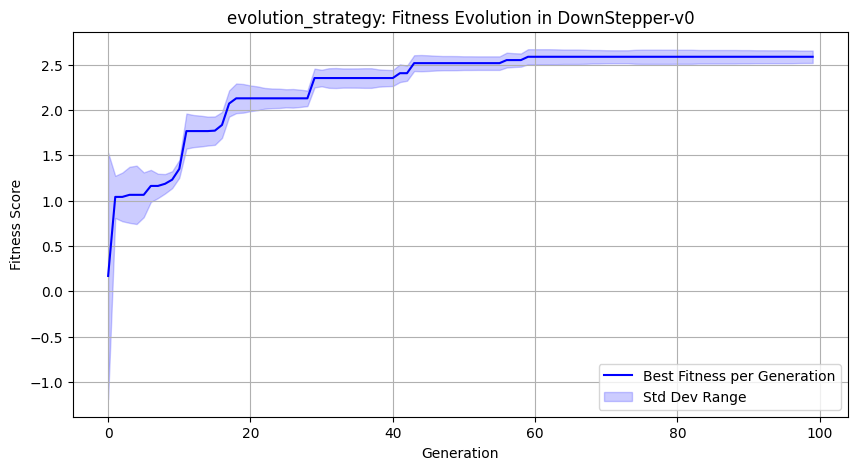


Best Weights: [array([[-0.60170992,  0.1379866 ,  1.0342064 , ...,  0.40001787,
        -1.08012012, -1.99915538],
       [ 1.16751681,  1.72132817, -0.85667705, ...,  1.1026344 ,
        -0.93349169,  0.41115536],
       [-0.68149545,  1.34893621,  2.55428961, ...,  0.61169958,
        -0.26656549, -0.45614042],
       ...,
       [-1.50914139, -0.82832623,  0.31437813, ..., -1.41386016,
         0.18865826,  1.79996182],
       [ 0.60403635, -1.47713026,  1.07097702, ..., -0.39466074,
        -2.67924443,  0.06824918],
       [ 2.36151124, -1.12152899,  0.94787284, ..., -1.97165749,
         0.18062066,  2.3667316 ]]), array([ 1.94845424, -0.28235066, -0.21819393,  1.52242396,  1.09365197,
        0.86124764, -2.35348741,  1.33895188,  1.06413516, -0.28450072,
       -0.98117007, -0.51232543,  1.41288631,  0.89350764,  0.07966828,
        0.76262165]), array([[-0.96479949,  0.15345343,  0.41410825,  0.69710567, -0.37100317,
        -1.27393098, -1.36045303,  1.22098703, -0.01822904,

In [8]:
# ---- RUN GA AND VISUALIZE RESULT ----
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(evolution_strategy, num_runs=1, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS)

print(f"\nBest Weights: {best_weights}")
print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# ---- VISUALIZE BEST POLICY ----
i = 0
while i < 10:
    visualize_policy(best_weights)
    i += 1

## Genetic Algorithm

In [9]:
# ---- PARAMETERS ----
POP_SIZE = 40
NUM_GENERATIONS = 100
MUTATION_STD = 0.1
ELITE_RATIO = 0.2
STEPS = 500
SCENARIO = 'DownStepper-v0'
# SEED = 42

# # ---- SEEDING ----
# np.random.seed(SEED)
# random.seed(SEED)
# torch.manual_seed(SEED)

# ---- ENVIRONMENT SETUP ----
robot_structure = np.array([
    [1, 3, 1, 0, 0],
    [4, 1, 3, 2, 2],
    [3, 4, 4, 4, 4],
    [3, 0, 0, 3, 2],
    [0, 0, 0, 0, 2]
])

connectivity = get_full_connectivity(robot_structure)
env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
sim = env.sim
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
env.close()

# ---- CONTROLLER INSTANCE ----
brain = NeuralController(input_size, output_size)

# ---- FITNESS FUNCTION ----
def evaluate_fitness(weights, view=False):
    set_weights(brain, weights)
    env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
    sim = env.sim
    viewer = EvoViewer(sim)
    viewer.track_objects('robot')

    state, _ = env.reset()
    total_reward = 0

    for t in range(STEPS):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = brain(state_tensor).detach().numpy().flatten()

        if view:
            viewer.render('screen')

        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    viewer.close()
    env.close()
    return total_reward

# ---- GENETIC OPERATORS ----
def initialize_population():
    return [[np.random.randn(*param.shape) for param in brain.parameters()] for _ in range(POP_SIZE)]

def mutate(individual):
    return [w + MUTATION_STD * np.random.randn(*w.shape) for w in individual]

def crossover(parent1, parent2):
    child = []
    for w1, w2 in zip(parent1, parent2):
        mask = np.random.rand(*w1.shape) < 0.5
        child_weights = np.where(mask, w1, w2)
        child.append(child_weights)
    return child

def select_parents(population, fitnesses):
    tournament_size = 3
    parents = []
    for _ in range(POP_SIZE):
        competitors = random.sample(list(zip(population, fitnesses)), tournament_size)
        best = max(competitors, key=lambda x: x[1])[0]
        parents.append(best)
    return parents

# ---- GENETIC ALGORITHM ----
def genetic_algorithm():
    population = initialize_population()
    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    start_time = time.time()

    for generation in range(NUM_GENERATIONS):
        fitnesses = [evaluate_fitness(ind) for ind in population]
        best_idx = np.argmax(fitnesses)

        best_fitness_scores.append(fitnesses[best_idx])
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        num_elites = int(ELITE_RATIO * POP_SIZE)
        elites = [population[i] for i in np.argsort(fitnesses)[-num_elites:]]

        parents = select_parents(population, fitnesses)
        offspring = [
            mutate(crossover(random.choice(parents), random.choice(parents)))
            for _ in range(POP_SIZE - num_elites)
        ]

        population = elites + offspring

        print(f"Gen {generation+1}: Best = {best_fitness_scores[-1]:.2f}, Mean = {mean_fitness_scores[-1]:.2f}")

    end_time = time.time()
    execution_time = end_time - start_time

    final_fitnesses = [evaluate_fitness(ind) for ind in population]
    best_idx = np.argmax(final_fitnesses)
    best_weights = population[best_idx]
    best_fitness = final_fitnesses[best_idx]

    return best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, execution_time, std_fitness_scores



Running genetic_algorithm 1/1...
Gen 1: Best = 0.57, Mean = -0.61
Gen 2: Best = 0.57, Mean = -0.68
Gen 3: Best = 0.94, Mean = -0.90
Gen 4: Best = 0.94, Mean = -0.76
Gen 5: Best = 0.94, Mean = -0.36
Gen 6: Best = 1.17, Mean = -0.57
SIMULATION UNSTABLE... TERMINATING
Gen 7: Best = 1.88, Mean = -0.41
Gen 8: Best = 1.89, Mean = -0.20
Gen 9: Best = 2.03, Mean = -0.16
Gen 10: Best = 2.03, Mean = -0.74
Gen 11: Best = 2.03, Mean = -0.80
Gen 12: Best = 2.03, Mean = -0.40
Gen 13: Best = 2.03, Mean = -0.04
Gen 14: Best = 2.03, Mean = -0.04
Gen 15: Best = 2.21, Mean = 0.76
Gen 16: Best = 2.23, Mean = 0.19
Gen 17: Best = 2.72, Mean = 1.00
Gen 18: Best = 2.99, Mean = 1.12
Gen 19: Best = 2.99, Mean = 1.33
Gen 20: Best = 2.99, Mean = 1.86
Gen 21: Best = 2.99, Mean = 1.02
Gen 22: Best = 3.11, Mean = 2.23
Gen 23: Best = 3.11, Mean = 2.12
Gen 24: Best = 3.37, Mean = 2.13
Gen 25: Best = 3.37, Mean = 2.17
Gen 26: Best = 3.37, Mean = 2.13
Gen 27: Best = 3.38, Mean = 2.00
Gen 28: Best = 3.38, Mean = 2.32
Ge

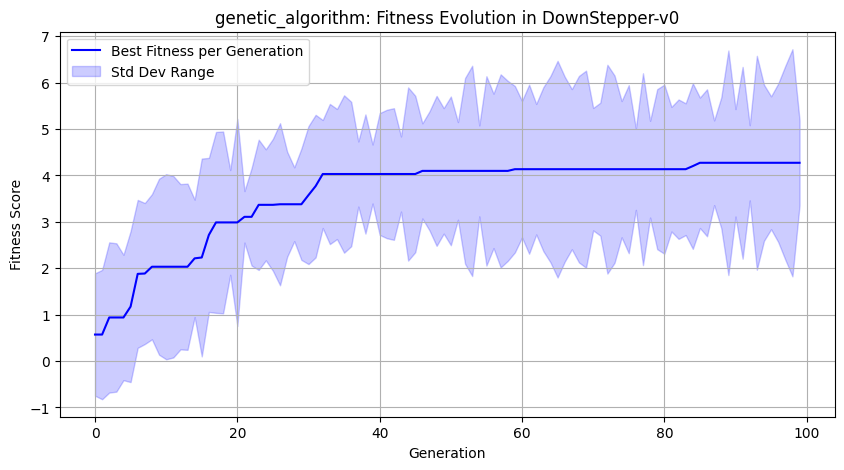


Best Weights: [array([[-1.01946821, -0.5328821 ,  0.01674172, ...,  1.10877935,
         0.25184886,  0.25302603],
       [ 1.20351379, -2.71457178, -1.71860881, ..., -0.9313945 ,
         0.70785585,  0.73405238],
       [-0.21617172,  0.64858478, -0.48737618, ...,  1.11413624,
        -0.34718006,  2.53777137],
       ...,
       [-0.43378151, -2.09840471,  0.65855094, ...,  2.2568514 ,
        -0.91810785,  0.01812062],
       [ 0.24145656, -2.29431531, -1.47077837, ..., -2.4521927 ,
        -0.22388006, -0.15353521],
       [ 0.42916432, -1.50854769, -1.66059427, ..., -0.35505029,
        -1.42745799,  0.87590843]]), array([-0.79718924, -0.90379662, -0.85198343, -0.05129557, -0.41908581,
        0.68939505, -0.80929636,  0.13922594,  0.36210124, -0.21893765,
        0.97705039, -0.36214444, -1.08001157, -0.18856644, -0.93354672,
        0.04183604]), array([[-2.742782  , -1.02558989, -1.02574056,  0.46315616,  2.64071692,
         1.02466572,  1.36167669, -0.00559293, -0.13439911,

In [10]:
# ---- RUN GA AND VISUALIZE RESULT ----
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(genetic_algorithm, num_runs=1, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS)
print(f"\nBest Weights: {best_weights}")

print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# ---- VISUALIZE BEST POLICY ----
i = 0
while i < 10:
    visualize_policy(best_weights)
    i += 1

## Differential Evolution

In [ ]:
# ---- PARAMETERS ----
POP_SIZE = 40
NUM_GENERATIONS = 100
F = 0.5                  # Mutation scaling factor
CR = 0.7                # Crossover rate (binomial)
STEPS = 500
SCENARIO = 'DownStepper-v0'
SEED = []

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# ---- ENVIRONMENT SETUP ----
robot_structure = np.array([
    [1, 3, 1, 0, 0],
    [4, 1, 3, 2, 2],
    [3, 4, 4, 4, 4],
    [3, 0, 0, 3, 2],
    [0, 0, 0, 0, 2]
])

connectivity = get_full_connectivity(robot_structure)
env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
sim = env.sim
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
env.close()

brain = NeuralController(input_size, output_size)

# ---- FITNESS FUNCTION ----
def evaluate_fitness(weights, view=False):
    set_weights(brain, weights)
    env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
    sim = env.sim
    viewer = EvoViewer(sim)
    viewer.track_objects('robot')

    state, _ = env.reset()
    total_reward = 0

    for t in range(STEPS):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = brain(state_tensor).detach().numpy().flatten()

        if view:
            viewer.render('screen')

        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    viewer.close()
    env.close()
    return total_reward

# ---- HELPER FUNCTIONS ----
def initialize_population():
    return [[np.random.randn(*param.shape) for param in brain.parameters()] for _ in range(POP_SIZE)]

def vectorize(individual):
    """Flatten weights into a single 1D vector."""
    return np.concatenate([w.flatten() for w in individual])

def devectorize(vector, shapes):
    """Convert 1D vector back into individual weight structure."""
    individual = []
    idx = 0
    for shape in shapes:
        size = np.prod(shape)
        values = vector[idx:idx + size].reshape(shape)
        individual.append(values)
        idx += size
    return individual

def binomial_crossover(target, mutant, cr):
    """Perform binomial crossover ensuring at least one gene changes."""
    size = len(target)
    trial = np.copy(target)
    rand_index = random.randint(0, size - 1)
    for i in range(size):
        if random.random() < cr or i == rand_index:
            trial[i] = mutant[i]
    return trial

# ---- DIFFERENTIAL EVOLUTION ----
def differential_evolution():
    population = initialize_population()
    shapes = [w.shape for w in population[0]]  # Save weight shapes
    pop_vectors = [vectorize(ind) for ind in population]
    fitnesses = [evaluate_fitness(devectorize(v, shapes)) for v in pop_vectors]

    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    start_time = time.time()

    for generation in range(NUM_GENERATIONS):
        new_population = []
        for i in range(POP_SIZE):
            # Choose three distinct individuals
            indices = list(range(POP_SIZE))
            indices.remove(i)
            a, b, c = random.sample(indices, 3)

            base = pop_vectors[a]
            diff = pop_vectors[b] - pop_vectors[c]
            mutant = base + F * diff

            target = pop_vectors[i]
            trial = binomial_crossover(target, mutant, CR)
            trial_ind = devectorize(trial, shapes)

            trial_fitness = evaluate_fitness(trial_ind)
            if trial_fitness > fitnesses[i]:
                new_population.append(trial)
                fitnesses[i] = trial_fitness
            else:
                new_population.append(target)  # keep original

        pop_vectors = new_population

        best = np.max(fitnesses)
        mean = np.mean(fitnesses)
        std = np.std(fitnesses)

        best_fitness_scores.append(best)
        mean_fitness_scores.append(mean)
        std_fitness_scores.append(std)

        print(f"Gen {generation+1}: Best = {best:.2f}, Mean = {mean:.2f}")

    end_time = time.time()
    execution_time = end_time - start_time

    best_idx = np.argmax(fitnesses)
    best_vector = pop_vectors[best_idx]
    best_weights = devectorize(best_vector, shapes)

    return best_weights, fitnesses[best_idx], best_fitness_scores, mean_fitness_scores, execution_time, std_fitness_scores


Running differential_evolution 1/1...
Gen 1: Best = 1.78, Mean = -0.15
Gen 2: Best = 1.78, Mean = 0.07
Gen 3: Best = 1.78, Mean = 0.13
Gen 4: Best = 1.78, Mean = 0.17
Gen 5: Best = 1.78, Mean = 0.30
Gen 6: Best = 1.78, Mean = 0.31
Gen 7: Best = 1.78, Mean = 0.33
Gen 8: Best = 1.78, Mean = 0.37
Gen 9: Best = 1.78, Mean = 0.40
Gen 10: Best = 1.78, Mean = 0.42
Gen 11: Best = 1.78, Mean = 0.43
Gen 12: Best = 1.78, Mean = 0.43
Gen 13: Best = 1.78, Mean = 0.48
Gen 14: Best = 1.78, Mean = 0.51
SIMULATION UNSTABLE... TERMINATING
Gen 15: Best = 1.78, Mean = 0.51
Gen 16: Best = 1.78, Mean = 0.53
Gen 17: Best = 1.78, Mean = 0.56
Gen 18: Best = 1.78, Mean = 0.56
Gen 19: Best = 1.78, Mean = 0.58
Gen 20: Best = 1.78, Mean = 0.59
Gen 21: Best = 1.78, Mean = 0.59
SIMULATION UNSTABLE... TERMINATING
Gen 22: Best = 1.78, Mean = 0.63
Gen 23: Best = 1.78, Mean = 0.63
Gen 24: Best = 1.78, Mean = 0.68
Gen 25: Best = 1.84, Mean = 0.74
Gen 26: Best = 1.84, Mean = 0.78
Gen 27: Best = 1.84, Mean = 0.81
Gen 28: 

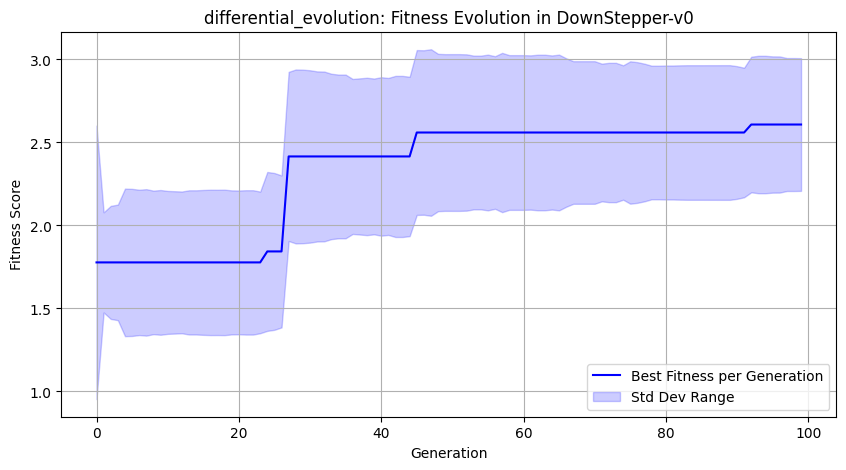


Best Weights: [array([[-3.63942008,  4.37406785,  7.92645581, ...,  7.96310598,
         2.84388973,  1.46460588],
       [ 2.28780292,  1.14614264, -0.65905972, ...,  3.87194495,
         1.9940422 , -0.48469545],
       [ 3.37059445,  4.77733599, -1.91043514, ...,  1.9677615 ,
         2.0736455 , -1.4923371 ],
       ...,
       [ 0.5259992 ,  1.30799716, -2.87385575, ..., -6.49527946,
        -0.84656176,  3.09796391],
       [-0.92396778, -3.87712561, -3.44961423, ..., -1.46223094,
         1.06169293,  0.82384392],
       [-1.82742023,  1.48135669, -2.57368722, ...,  0.67752027,
        -0.77685043,  3.96763965]]), array([-1.71117741, -1.91738583,  0.83084785, -5.04215603, -1.43568788,
        1.04344689,  8.30068911, -3.17775096,  3.86685171, -2.37949412,
        3.39747318, -1.69120293,  0.20037768, -0.88403289, -1.0177572 ,
       -2.3222442 ]), array([[ 4.96077100e+00, -2.03475615e-01, -2.33468733e+00,
         3.38414796e+00,  6.03415244e-01, -3.67221764e+00,
        -3.194

In [5]:
# RUN DE AND VISUALIZE RESULT
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(differential_evolution, num_runs=1, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS)
print(f"\nBest Weights: {best_weights}")
print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# ---- VISUALIZE BEST POLICY ----
i = 0
while i < 10:
    visualize_policy(best_weights)
    i += 1

## CMA-ES